# Model testing with quadratic, exponential, and other reward functions on Env-v1

In [7]:
# More tests in reward_testing.py

In [8]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp
import pandas as pd

import gym_gyroscope_env
import spinup
import torch
from functools import partial

from custom_functions.custom_functions import env_fn 
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import test_agent
from custom_functions.custom_functions import plot_test
from custom_functions.custom_functions import evaluate_control
from custom_functions.custom_functions import read_progress

import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

## Plot rewards

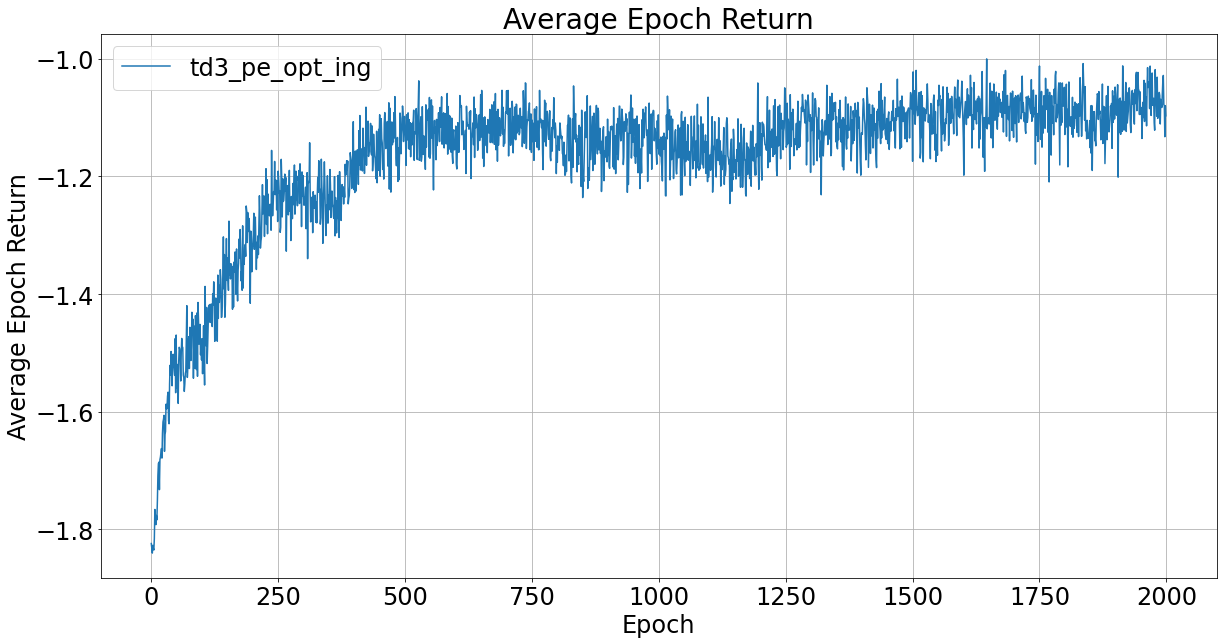

In [9]:
plt.figure(figsize=(20,10))
plt.title('Average Epoch Return',fontsize=28)
plt.xlabel('Epoch',fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel('Average Epoch Return',fontsize=24)
plt.yticks(fontsize=24)
plt.grid()


agent_paths = ['td3_pe_opt_ing']
# agent_paths = ['sac_q', 'sac_a', 'sac_n', 'sac_n_2505', 'sac_q_ep', 'sac_q_p', 'sac_q_b', 'sac_n_b', 'sac_s', 'sac_p01e40', 'sac_p01e80', 'sac_p005', 'sac_p05', 'sac_p01', 'sac_e10', 'sac_e20', 'sac_e40', 'sac_p005_gamma095', 'sac_p005_gamma1']   # 'sac_q_e'训练了2000次
# agent_paths = ['ddpg_a','ddpg_n','ddpg_n_b','ddpg_q','ddpg_q_b','ddpg_q_e','ddpg_q_ep','ddpg_q_p','ddpg_s']
# agent_paths = ['ddpg_p005','ddpg_p01','ddpg_p05','ddpg_p005_gamma095','ddpg_p005_gamma1']
# agent_paths = ['ddpg_e10','ddpg_e20','ddpg_e40','ddpg_p01e40','ddpg_p01e80']
# agent_paths = ['ddpg_e10_2000epochs','ddpg_e20_2000epochs','ddpg_e40_2000epochs',
#                'ddpg_p01e40_2000epochs','ddpg_p01e80_2000epochs']

for agent_path in agent_paths[:]:
    progress = read_progress(agent_path)   # ddpg是19维度，sac是27维度，需要分别绘制
    plt.plot(np.arange(progress.shape[0]), progress[:,1]/abs(max(progress[:,1])))
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,3], progress[:,4], alpha=0.5)
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,1]+progress[:,2], progress[:,1]-progress[:,2], alpha=0.5)

# plt.xlim([0,500])
# plt.ylim([-2000,0])
plt.legend(agent_paths,fontsize=24)
# plt.legend(['Q','A','N','EP','QP','QE','QB','NB', 'S', 'PE0140', 'PE0180', 'Power005', 'Power05', 'Power01', 'Exponential10', 'Exponential20', 'Exponential40', 'Power005_gamma095', 'Power005_gamma1'],fontsize=16)
# plt.legend([r'p=0.05,$\gamma$=0.995','p=0.1,$\gamma$=0.995','p=0.5,$\gamma$=0.995','p=0.05,$\gamma$=0.95'],fontsize=24)
# plt.legend(['c=-10','c=-20','c=-40'],fontsize=24)
# plt.savefig('quad_epoch.png')
# plt.savefig('power_epoch.png')
# plt.savefig('exp_epoch.png')
plt.savefig('tmp.png')

## Test an agent

i was here [ 0.99678415 -0.9999987 ]
i was here [ 0.07556386 -0.9998933 ]
i was here [ 0.21396472 -0.998595  ]
i was here [-0.9916669  -0.97854257]
i was here [-0.99771285 -0.4554011 ]
i was here [-0.9994074  -0.23309179]
i was here [-0.9994134  -0.61915135]
i was here [-0.9526132  -0.09165338]
i was here [-0.3408224   0.08270641]
i was here [-0.06434797  0.12821431]
i was here [-0.04052948  0.05615429]
i was here [0.00693701 0.04258641]
i was here [-0.00350173  0.03553804]
i was here [-0.00041902  0.02598544]
i was here [0.00036255 0.01958002]
i was here [0.00069311 0.01470163]
i was here [0.00090572 0.01102349]
i was here [0.0009726  0.00826154]
i was here [0.00097427 0.00618067]
i was here [0.00094271 0.00461425]


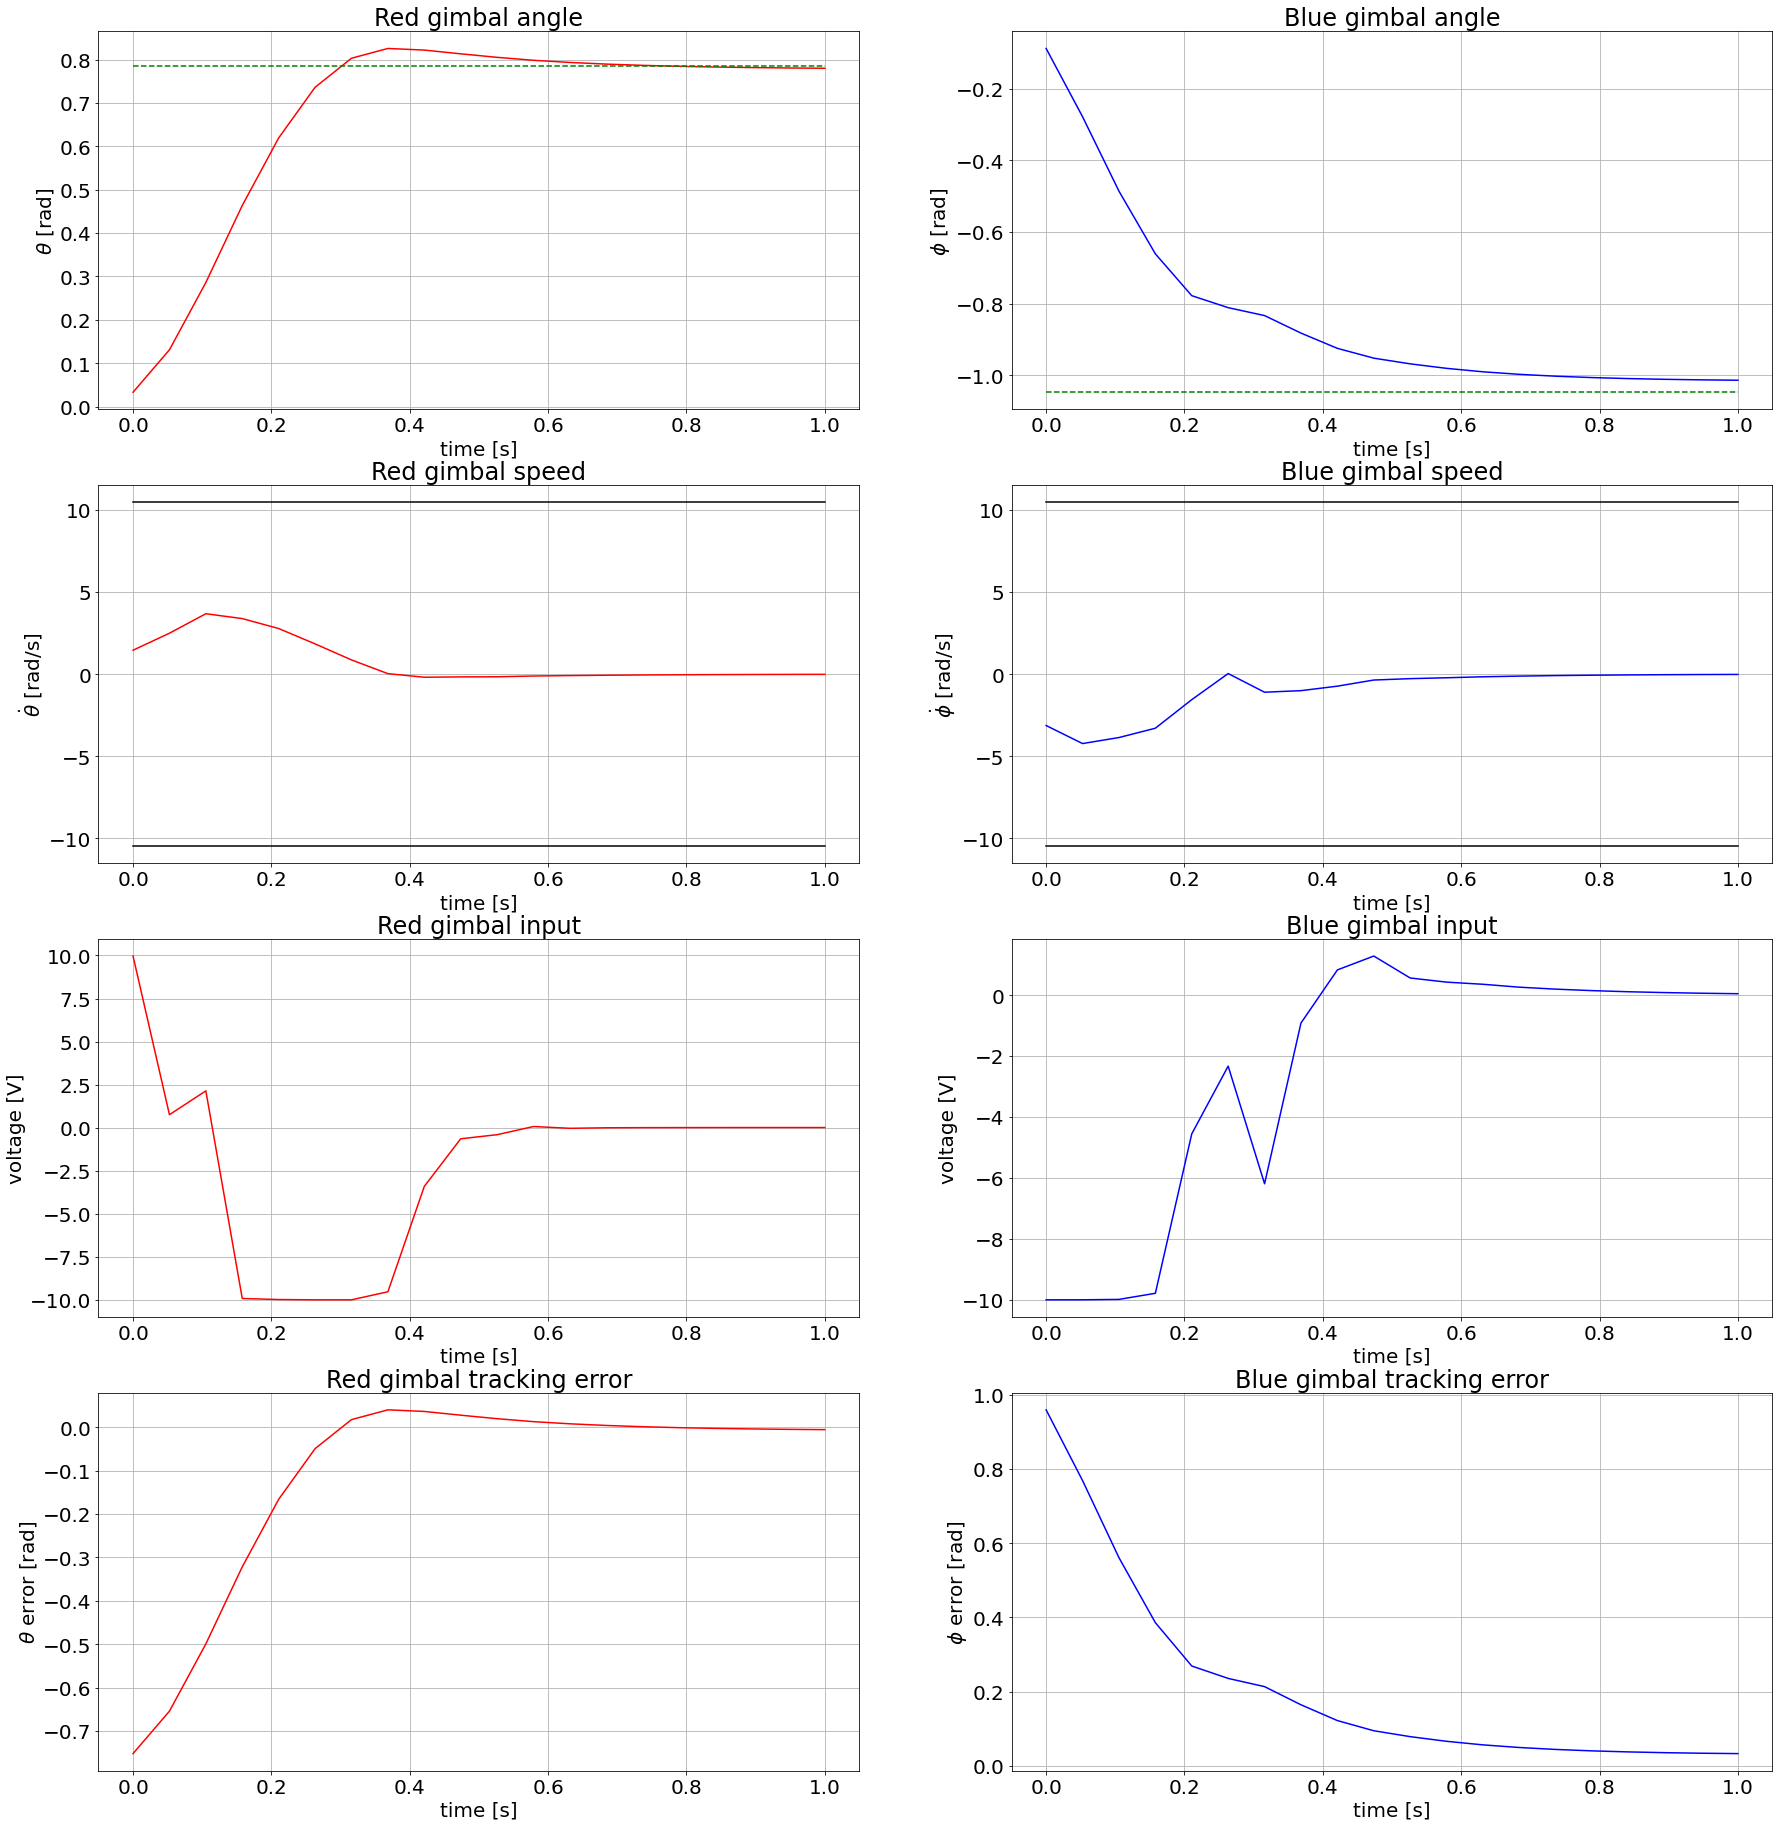

-0.37499410553252577

In [10]:
# Test paramaters
env_name = 'GyroscopeEnv-v1'  # GyroscopeRealEnv-v0， GyroscopeEnv-v1, GyroscopeIntegralEnv-v1

init_state = np.array([0,0,0,0,45/180*np.pi,-60/180*np.pi,200/60*2*np.pi])
env = create_env(env_name,state=init_state)

# agent_paths = ['sac_q', 'sac_q_ep', 'sac_q_p', 'sac_q_e', 'sac_q_b']   # Quadratic
# agent_paths = ["sac_q_opt_001", "sac_q_opt_002", "sac_q_opt_003"]   # Quadratic---opt
# agent_paths = ['sac_a']   # Absolute
# agent_paths = ['sac_n', 'sac_n_2505', 'sac_n_b']   # Normalized
# agent_paths = ['sac_s']   # Sparse
agent_paths = ['td3_pe_opt_ing']   # PE
# agent_paths = ['sac_pe_opt', "sac_pe_opt001", "sac_pe_opt002", "sac_pe_opt003", "sac_pe_opt004", "sac_pe_opt005", "sac_pe_opt006", "sac_pe_opt007", "sac_pe_opt_ing"]   # PE---opt
# agent_paths = ['sac_p005', 'sac_p05', 'sac_p01']   # Power
# agent_paths = ['sac_e10', 'sac_20', 'sac_e40']   # Exponential
# agent_paths = ['sac_p005_gamma095', 'sac_p005_gamma1']   # Power
# agent_paths = ["ddpg_compare"]

agent = load_agent(agent_paths[0])
t_end = 1

score, state_record, obs_record, action_record, reward_record = test_agent(env,agent,t_end)
plot_test(state_record, action_record, t_end, 4)   # 显示所有的测试，更价值观清晰
score

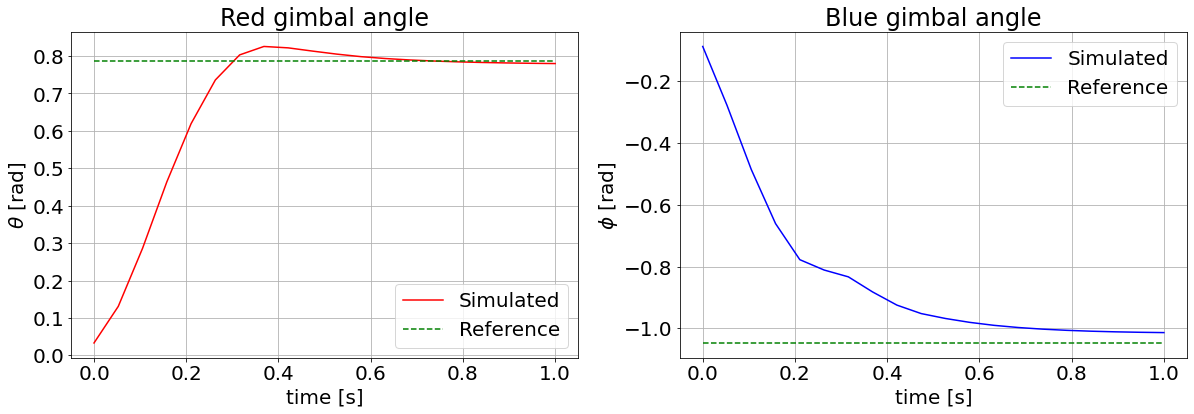

In [11]:
time = np.linspace(0, t_end, len(state_record))
n = 1
f, axs = plt.subplots(n,2,figsize=(20,6*n))

plt.subplot(n,2,1)
plt.title('Red gimbal angle',fontsize=24)
plt.xlabel('time [s]',fontsize=20)
plt.ylabel(r'$\theta$ [rad]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.plot(time,env.angle_normalize(state_record[:,0]),'r-')
plt.plot(time,env.angle_normalize(state_record[:,4]),'g--')
# plt.plot(time,np.full(len(time),180), 'k-')
# plt.plot(time,np.full(len(time),-180), 'k-')
plt.legend(['Simulated','Reference'],fontsize=20)

plt.subplot(n,2,2)
plt.title('Blue gimbal angle',fontsize=24)
plt.xlabel('time [s]',fontsize=20)
plt.ylabel(r'$\phi$ [rad]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.plot(time,env.angle_normalize(state_record[:,2]),'b-')
plt.plot(time,env.angle_normalize(state_record[:,5]),'g--')
# plt.plot(time,np.full(len(time),180), 'k-')
# plt.plot(time,np.full(len(time),-180), 'k-')
plt.legend(['Simulated','Reference'],fontsize=20)

plt.savefig('tmp.png')


In [6]:
a = [0.99945,0.99145,0.95937,0.89445,0.81430,0.74112,0.69454,0.67814,0.68087]

agent = torch.load("/media/xiongyan/Data_Repositories/Project_code/Gyro_MBRL/Gyro_MBRL/code/Basic_code/td3_reward_function_comparision/td3_pe_opt_ing/pyt_save/model.pt")

agent(a)

agent

# bbb = agent(a)


NotImplementedError: 

## Evaluate control performance

In [ ]:
metrics_QAN = pd.read_csv('Metrics_QAN.csv')
metrics_QAN

In [ ]:
metrics_PE = pd.read_csv('Metrics_PE.csv')
metrics_PE
# print(metrics_PE.iloc[0:8,[0,4,5,6]].to_latex(index=False,escape=False))

In [ ]:
# m = pd.concat([metrics_PE.iloc[:,:4], metrics_QAN.iloc[:,1], metrics_P005.iloc[:,2]],axis=1)
# print(m.to_latex(index=False,escape=False))

In [ ]:
# metrics_P005_1 = pd.read_csv('Metrics_PE.csv')
# metrics_P005_2 = pd.read_csv('Metrics_Pgamma.csv')
# metrics_P005_3 = pd.read_csv('Metrics_Plen.csv')
# metrics_P005 = pd.concat([metrics_P005_1.iloc[:,:2],metrics_P005_2.iloc[:,1:],metrics_P005_3.iloc[:,1:]],axis=1)
# metrics_P005 = metrics_P005.round(4)
# metrics_P005.to_csv('Metrics_P005.csv',index=False)

In [ ]:
metrics_P005 = pd.read_csv('Metrics_P005.csv')
metrics_P005

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Average Q value',fontsize=28)
plt.xlabel('Epoch',fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel('Average Q value',fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

agent_paths = ['ddpg_p005','ddpg_p005_gamma095']

for agent_path in agent_paths:
    progress = read_progress(agent_path)
    plt.plot(np.arange(progress.shape[0]), progress[:,12])
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,14], progress[:,15], alpha=0.5)
    plt.fill_between(np.arange(progress.shape[0]), progress[:,12]+progress[:,13], progress[:,12]-progress[:,13], alpha=0.5)

plt.legend(agent_paths,fontsize=24)

In [ ]:
assert False

## Why p = 0.05 doesn't learn with gamma = 0.995

In [ ]:
agent_path = 'ddpg_p005'
path = agent_path + '/pyt_save/model.pt'
ac = torch.load(path)

In [ ]:
gamma = 0.995
te = np.arange(-np.pi,np.pi,0.01)
es = np.zeros([len(te),1])
rs = np.zeros([len(te),1])
qs = np.zeros([len(te),1])
ys = np.zeros([len(te),1])
for i in range(len(te)):
    o = torch.as_tensor(env.reset([te[i],0,0,0,0,0,200/60*2*np.pi]), dtype=torch.float32)
    a = ac.pi(o)
    q = ac.q(o,a).detach().numpy()
    o2, r, _, _ = env.step(a.detach().numpy())
    o2 = torch.as_tensor(o2, dtype=torch.float32)
    a2 = ac.pi(o2)
    q2 = ac.q(o2,a2).detach().numpy()
    y = r + gamma*q2
    es[i] = q - y
    rs[i] = r
    qs[i] = q
    ys[i] = y
plt.plot(qs)
plt.plot(ys)
# plt.plot(es/rs)
# plt.plot(es)

In [ ]:
gamma = 0.995
es = np.zeros([len(obs_record)-1,1])
rs = np.zeros([len(obs_record)-1,1])
qs = np.zeros([len(obs_record)-1,1])
ys = np.zeros([len(obs_record)-1,1])
for i in range(len(obs_record)-1):
    o = torch.as_tensor(obs_record[i], dtype=torch.float32)
    a = ac.pi(o)
    q = ac.q(o,a).detach().numpy()
    o2 = torch.as_tensor(obs_record[i+1], dtype=torch.float32)
    a2 = ac.pi(o2)
    q2 = ac.q(o2,a2).detach().numpy()
    y = reward_record[i+1] + gamma*q2
    es[i] = q - y
    rs[i] = reward_record[i+1]
    qs[i] = q
    ys[i] = y
plt.plot(qs)
plt.plot(ys)
# plt.plot(es/rs)
# plt.plot(es)

In [ ]:
env.reset([np.pi*1/2,0,np.pi*1/2,0,0,0,200/60*2*np.pi])
o_90 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([np.pi*1/3,0,np.pi*1/3,0,0,0,200/60*2*np.pi])
o_60 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([np.pi*1/6,0,np.pi*1/6,0,0,0,200/60*2*np.pi])
o_30 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([0,0,0,0,0,0,200/60*2*np.pi])
o_0 = torch.as_tensor(env.observation, dtype=torch.float32)

x = np.arange(-1,1,0.01)
y = np.arange(-1,1,0.01)
X, Y = np.meshgrid(x, y)

q_90 = np.zeros([x.shape[0],y.shape[0]])
q_60 = np.zeros([x.shape[0],y.shape[0]])
q_30 = np.zeros([x.shape[0],y.shape[0]])
q_0 = np.zeros([x.shape[0],y.shape[0]])

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        a = torch.as_tensor([x[i], y[j]], dtype=torch.float32)
        q_90[i][j] = ac.q(o_90, a).detach().numpy()
        q_60[i][j] = ac.q(o_60, a).detach().numpy()
        q_30[i][j] = ac.q(o_30, a).detach().numpy()
        q_0[i][j] = ac.q(o_0, a).detach().numpy()

In [ ]:
f, axs = plt.subplots(2,2,figsize=(20,20))
extent = [-1,1,-1,1]

plt.subplot(2,2,1)
plt.imshow(q_90,extent=extent)
plt.colorbar()
plt.title('90 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,2)
plt.imshow(q_60,extent=extent)
plt.colorbar()
plt.title('60 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,3)
plt.imshow(q_30,extent=extent)
plt.colorbar()
plt.title('30 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,4)
plt.imshow(q_0,extent=extent)
plt.colorbar()
plt.title('0 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.show()

In [ ]:
agent_path = 'ddpg_p005_gamma095'
path = agent_path + '/pyt_save/model.pt'
ac = torch.load(path)

In [ ]:
gamma = 0.95
te = np.arange(-np.pi,np.pi,0.01)
e = np.zeros([len(te),1])
qs = np.zeros([len(te),1])
ys = np.zeros([len(te),1])
for i in range(len(te)):
    o = torch.as_tensor(env.reset([te[i],0,0,0,0,0,200/60*2*np.pi]), dtype=torch.float32)
    a = ac.pi(o)
    q = ac.q(o,a).detach().numpy()
    o2, r, _, _ = env.step(a.detach().numpy())
    o2 = torch.as_tensor(o2, dtype=torch.float32)
    a2 = ac.pi(o2)
    q2 = ac.q(o2,a2).detach().numpy()
    y = r + gamma*q2
    e[i] = q - y
    qs[i] = q
    ys[i] = y
plt.scatter(te, qs)
# plt.plot(ys)
# plt.scatter(te, e)

In [ ]:
env.reset([np.pi*1/2,0,np.pi*1/2,0,0,0,200/60*2*np.pi])
o_90 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([np.pi*1/3,0,np.pi*1/3,0,0,0,200/60*2*np.pi])
o_60 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([np.pi*1/6,0,np.pi*1/6,0,0,0,200/60*2*np.pi])
o_30 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([0,0,0,0,0,0,200/60*2*np.pi])
o_0 = torch.as_tensor(env.observation, dtype=torch.float32)

x = np.arange(-1,1,0.01)
y = np.arange(-1,1,0.01)
X, Y = np.meshgrid(x, y)

q_90 = np.zeros([x.shape[0],y.shape[0]])
q_60 = np.zeros([x.shape[0],y.shape[0]])
q_30 = np.zeros([x.shape[0],y.shape[0]])
q_0 = np.zeros([x.shape[0],y.shape[0]])

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        a = torch.as_tensor([x[i], y[j]], dtype=torch.float32)
        q_90[i][j] = ac.q(o_90, a).detach().numpy()
        q_60[i][j] = ac.q(o_60, a).detach().numpy()
        q_30[i][j] = ac.q(o_30, a).detach().numpy()
        q_0[i][j] = ac.q(o_0, a).detach().numpy()

In [ ]:
f, axs = plt.subplots(2,2,figsize=(20,20))
extent = [-1,1,-1,1]

plt.subplot(2,2,1)
plt.imshow(q_90,extent=extent)
plt.colorbar()
plt.title('90 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,2)
plt.imshow(q_60,extent=extent)
plt.colorbar()
plt.title('60 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,3)
plt.imshow(q_30,extent=extent)
plt.colorbar()
plt.title('30 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,4)
plt.imshow(q_0,extent=extent)
plt.colorbar()
plt.title('0 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.show()